In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from scipy import signal
import random
RANDOM_STATE = 17
random.seed(RANDOM_STATE)
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
#Global setpoints 
columns_input = ['line_2_inp_flow','line_2_out_flow','power']
columns_analyze = ['line_2_inp_flow','power','target_delta_flow']
columns_fit = ['line_2_inp_flow','power'] 
target_name = 'target_delta_flow' #name for model target

csv_separator = ';' #'\t'

N_MEAN_ROLLING = 2 #Apply mean rolling for all set
N_SELECT = 1 #Take only each N-s entry for analyse
N_PREV = 10 #Time back window size
N_MIN_SUBGROUP = 13 #Limit sub groups minimum size. Used for butter filter. Eg butter filter requires minimum 13 elements.
PLNM = False #Aply polynomial or not
PCA_EN = False #Apply PCA or not

In [3]:
#Pipeline parameters
pca = PCA(0.99, random_state = RANDOM_STATE)
scaler = StandardScaler()
polynom = PolynomialFeatures(degree=2)

In [4]:
#Project specific funtions

def preprocess_data_df(inp_df):  #Preprocess as pandas df
    """
    Custom preprocessing of data frame
    """
    inp_df['target_delta_flow'] = inp_df['line_2_out_flow'] - inp_df['line_2_inp_flow']
    #inp_df['power_filtered'] = inp_df['power']
    #inp_df['target_delta_nofilter'] = inp_df['target_delta_flow']

def preprocess_data_np(inp_np):  #Preprocess as np array
    """
    Custom preprocessing of np array
    """
    #nothing
    
#Filtering    
b, a = signal.butter(3, 0.1)

def filtering(inp_data, columns=None):
    if columns:
        return np.transpose([signal.filtfilt(b, a, inp_data[:,i]) if i in columns_filtered_int else inp_data[:,i] for i in range(inp_data.shape[1])])
    else:
        return signal.filtfilt(b, a, inp_data, axis=0)


In [17]:
#Base functions

def get_indexes(inp_main, inp_search):
    return [inp_main.index(i) for i in inp_search]

def get_index(inp_main, inp_search):
    return inp_main.index(inp_search)

columns_filtered = ['line_2_inp_flow','power','target_delta_flow']
columns_filtered_int = get_indexes(columns_analyze, columns_filtered)
columns_fit_int = get_indexes(columns_analyze,columns_fit)
target_index = get_index(columns_analyze,target_name)

def rolling_mean_along_axis(inp):
    return np.convolve(inp, np.ones(N_MEAN_ROLLING), 'valid') / N_MEAN_ROLLING    
    
def rolling_mean(inp):
    return np.apply_along_axis(rolling_mean_along_axis, 0, inp)

def pca_scaler_data(inp_data,fit_en,pca_en,plnm):  
    if len(inp_data) !=0:
        if fit_en:
            X_tr_sc  = scaler.fit_transform(inp_data)
            if plnm:
                X_tr_sc = polynom.fit_transform(X_tr_sc)
            if pca_en:
                X_tr_sc = pca.fit_transform(X_tr_sc)
        else:
            X_tr_sc  = scaler.transform(inp_data)
            if plnm:
                X_tr_sc  = polynom.transform(X_tr_sc)
            if pca_en:
                X_tr_sc = pca.transform(X_tr_sc)   
    else:
        X_tr_sc = inp_data
        
    if len(inp_data) !=0:
        X_tst_sc = scaler.transform(inp_data)
        if plnm:
            X_tst_sc = polynom.transform(X_tst_sc)
        if pca_en:
            X_tst_sc = pca.transform(X_tst_sc)
    else:
        X_tst_sc = inp_data
    return X_tst_sc 

def load_data(inp_X,inp_y, n_prev):  
    buffer_X, buffer_Y = [], []
    for i in range(len(inp_X)-n_prev+1):
        buffer_X.append(inp_X[i:i+n_prev])
        buffer_Y.append(np.array(inp_y)[i+n_prev-1])
    result_X = np.array(buffer_X)
    result_Y = np.array(buffer_Y)
    return result_X, result_Y 

In [24]:
data_stack = []

merge = False
fit_en = True
test_size = 0.2

for j in ['./data/export_20171026.txt','./data/export_20171027.txt']:
    inp_data = pd.read_csv(j, sep=csv_separator, header = 0)
    inp_data.columns = columns_input

    print("Initial lenght of %a data file is %s"%(j,len(inp_data)))

    #Preprocess
    preprocess_data_df(inp_data)
    
    #Select used columns
    inp_data = inp_data[columns_analyze] 
    
    #Remove nans rows
    inp_data_has_nan = inp_data.isnull().values.any()
    inp_data.dropna(inplace=True)
    
    #We don't use windows with gaps for analyse
    #Some trick to find the gaps - where index jumps
    
    gap_indexes = [len(inp_data)]
    if not merge:
        gap_indexes = np.append(np.where(np.roll(inp_data.index, -1)-inp_data.index>1)[0]+1, gap_indexes)
        
    #Convert to np.array
    inp_data = np.array(inp_data)

    #Split input file by gaps
    prev_gap_index=0
    for gap_index in gap_indexes:
        sub_len = gap_index-prev_gap_index
        min_size = max(N_MEAN_ROLLING,N_SELECT*N_PREV,N_MIN_SUBGROUP)
        if (sub_len>=min_size):
            sub_arr = inp_data[prev_gap_index:gap_index]
            data_stack.append(sub_arr)
        prev_gap_index = gap_index

data_merged = np.array([])

#Merging data and process data
if not merge:
    len_stack = []
    for idx,n in enumerate(data_stack):
        res = filtering(n, columns=columns_filtered_int) 
        res = rolling_mean(res)
        data_stack[idx] = res[0::N_SELECT]
        #Record sub data mapping
        len_stack.append(len(data_stack[idx]))
        print("Length of filtered sub data piece withount merging is %s"%(len(data_stack[idx])))
        
    #Fit scaler on trainig data and use for transformation of test data
    data_merged = np.concatenate(data_stack, axis=0)
    
    #Separate X and Y data
    X_full_unscaled = data_merged[:,columns_fit_int]
    y_full = data_merged[:,target_index]
    
    num_training = round(len(data_fit) * (1 - test_size))
    
    X_train_unscaled = X_full_unscaled[0:num_training] 
    X_test_unscaled  = X_full_unscaled[num_training:] 
    X_train_scaled = pca_scaler_data(X_train_unscaled, fit_en, PCA_EN, PLNM)
    X_test_scaled  = pca_scaler_data(X_test_unscaled, False, PCA_EN, PLNM)
    
    if len(X_train_scaled) == 0:
        X_full = X_test_scaled
    elif len(X_test_scaled) == 0:
        X_full = X_train_scaled
    else:
        X_full = np.concatenate((X_train_scaled,X_test_scaled), axis=0)
        
    pointer_beg = 0
    pointer_end = 0
    buffer_X = []
    buffer_y = []
    for v in len_stack:
        pointer_end += v
        X_part,y_part = load_data(X_full[pointer_beg:pointer_end],y_full[pointer_beg:pointer_end],N_PREV)
        pointer_beg += v
        buffer_X.append(X_part)
        buffer_y.append(y_part)
        
    X_full_win = np.concatenate(buffer_X)   
    y_full_win = np.concatenate(buffer_y)
    
    X_train, y_train = X_full_win[0:num_training,:], y_full_win[0:num_training]
    X_test, y_test   = X_full_win[num_training:,:], y_full_win[num_training:]    
    
    print(X_full_win)
    
else:
    data_merged = np.concatenate(data_stack, axis=0)
    print(data_merged)
    data_merged = filtering(data_merged, columns=columns_filtered_int) 
    print(data_merged)
    data_merged = rolling_mean(data_merged)
    print(data_merged)
    data_merged = data_merged[0::N_SELECT]
    print(data_merged)
    print("Length of filtered and merged data is %s"%(len(data_merged)))
    


#X_train_,X_test_ = X_train_test_split_df(df_[columns_fit],test_size)
#X_train_scaled = _pca_scaler_data(X_train_,fit_en,pca_en,plnm)
#X_test_scaled  = _pca_scaler_data(X_test_,False,pca_en,plnm)


Initial lenght of './data/export_20171026.txt' data file is 50
Initial lenght of './data/export_20171027.txt' data file is 11
Length of filtered sub data piece withount merging is 12
Length of filtered sub data piece withount merging is 12
[[[-1.07265146  2.33595238]
  [-0.99419825  1.83317884]
  [-0.91875532  1.36445294]
  [-0.84815426  0.94770897]
  [-0.7840817   0.59511889]
  [-0.72789824  0.31265431]
  [-0.68045635  0.1005376 ]
  [-0.64199657 -0.04574954]
  [-0.61215133 -0.13418538]
  [-0.59003747 -0.17487257]]

 [[-0.99419825  1.83317884]
  [-0.91875532  1.36445294]
  [-0.84815426  0.94770897]
  [-0.7840817   0.59511889]
  [-0.72789824  0.31265431]
  [-0.68045635  0.1005376 ]
  [-0.64199657 -0.04574954]
  [-0.61215133 -0.13418538]
  [-0.59003747 -0.17487257]
  [-0.57440231 -0.17880134]]

 [[-0.91875532  1.36445294]
  [-0.84815426  0.94770897]
  [-0.7840817   0.59511889]
  [-0.72789824  0.31265431]
  [-0.68045635  0.1005376 ]
  [-0.64199657 -0.04574954]
  [-0.61215133 -0.13418538]


NameError: name 'df' is not defined

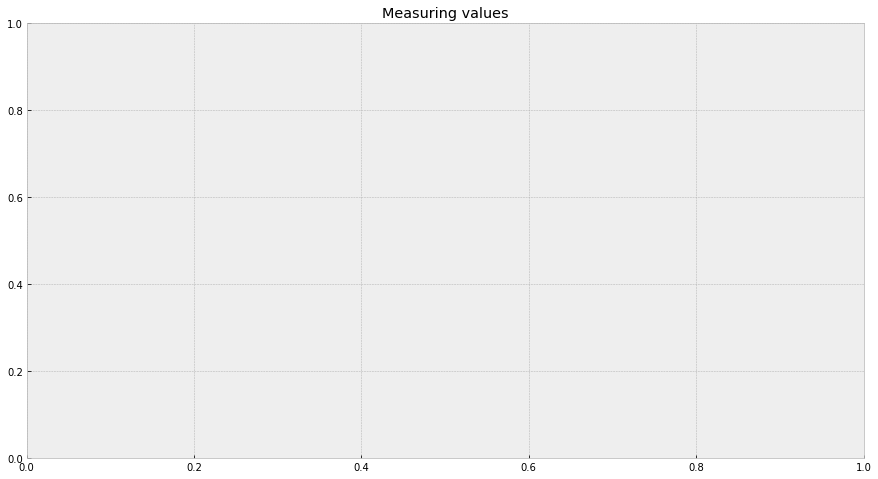

In [25]:
#строим обрезанные данные 
with plt.style.context('bmh'):    
    plt.figure(figsize=(15, 8))
    plt.title('Measuring values')
    df_rescaled = pd.DataFrame(StandardScaler().fit_transform(df))
    #df_rescaled = pd.DataFrame(MinMaxScaler(feature_range=(-1, 1)).fit_transform(df))
    for k in df_rescaled.columns:
        plt.plot(df_rescaled[k]);
    plt.legend(loc="best")